In [1]:
import numpy as np

In [98]:
fname = "twomoons.txt"
data = np.loadtxt(open(fname,'r'))
np.random.shuffle(data)
train_split = int(0.6*data.shape[0])
val_split = int(0.8*data.shape[0])
data_train = data[:train_split,:]
data_val = data[train_split:val_split,:]
data_test = data[val_split:,:]

In [99]:
import pylab

In [100]:
# fonction plot
#TODO - change to a functional import statement
def gridplot(classifieur,train,test,n_points=50, classifier_type = 'gauss'):

    train_test = np.vstack((train,test))
    (min_x1,max_x1) = (min(train_test[:,0]),max(train_test[:,0]))
    (min_x2,max_x2) = (min(train_test[:,1]),max(train_test[:,1]))

    xgrid = np.linspace(min_x1,max_x1,num=n_points)
    ygrid = np.linspace(min_x2,max_x2,num=n_points)

	# calcule le produit cartesien entre deux listes
    # et met les resultats dans un array
    thegrid = np.array(combine(xgrid,ygrid))
    les_comptes = classifieur.compute_predictions(thegrid)
    
    classesPred = np.argmax(les_comptes,axis=1)+1

    # La grille
    # Pour que la grille soit plus jolie
    #props = dict( alpha=0.3, edgecolors='none' )
    pylab.scatter(thegrid[:,0],thegrid[:,1],c = classesPred, s=50, edgecolor='black', linewidth='1', label='grid')
	# Les points d'entrainment
    pylab.scatter(train[:,0], train[:,1], c = train[:,-1], marker = 'v', s=50,edgecolor='black', linewidth='1', label = 'train')
    # Les points de test
    pylab.scatter(test[:,0], test[:,1], c = test[:,-1], marker = 's', s=50,edgecolor='black', linewidth='1', label = 'test')

    ## Un petit hack, parce que la fonctionalite manque a pylab...
    h1 = pylab.plot([min_x1], [min_x2], marker='o', c = 'w',ms=1) 
    h2 = pylab.plot([min_x1], [min_x2], marker='v', c = 'w',ms=1) 
    h3 = pylab.plot([min_x1], [min_x2], marker='s', c = 'w',ms=1) 
    #handles = [h1,h2,h3]
    ## fin du hack

    labels = ['grille','train','test']
    #pylab.legend(handles=[h1,h2,h3],labels=['grille','train','test'])
    pylab.legend(loc=2, fontsize='small')
    pylab.axis('equal')
    pylab.show()

    ## http://code.activestate.com/recipes/302478/
def combine(*seqin):
    '''returns a list of all combinations of argument sequences.
for example: combine((1,2),(3,4)) returns
[[1, 3], [1, 4], [2, 3], [2, 4]]'''
    def rloop(seqin,listout,comb):
        '''recursive looping function'''
        if seqin:                       # any more sequences to process?
            for item in seqin[0]:
                newcomb=comb+[item]     # add next item to current comb
                # call rloop w/ rem seqs, newcomb
                rloop(seqin[1:],listout,newcomb)
        else:                           # processing last sequence
            listout.append(comb)        # comb finished, add to list
    listout=[]                      # listout initialization
    rloop(seqin,listout,[])         # start recursive process
    return listout

In [113]:
def onehotify(labels,num_classes):
    labels = labels.astype(int)
    onehots = np.zeros((labels.shape[0],num_classes))
    onehots[np.arange(labels.shape[0]),labels] = 1
    return onehots

class NeuralNet_single:
    def __init__(self,dimensions, num_classes,weight_decay=[0,0]):
        self.weights = [0]*(len(dimensions)-1)
        self.saved_weights = [0]*(len(dimensions)-1)
        self.biases = [0]*(len(dimensions)-1)
        self.saved_biases = [0]*(len(dimensions)-1)
        for i in range(len(dimensions)-1):
            self.weights[i] = np.random.uniform(low=(-1)/float((np.sqrt(dimensions[i]))),
                                                high=(1)/float((np.sqrt(dimensions[i]))),
                                                size=((dimensions[i+1],dimensions[i]))
                                               )
            self.saved_weights[i] = self.weights[i]
            self.biases[i] = np.zeros((dimensions[i+1]))
            self.saved_biases[i] = self.biases[i]
        self.num_classes = num_classes
        self.weight_decay = weight_decay
        
        
    def loss(self,logit,label):
        loss = -np.log(logit[np.argmax(label)])
        return loss
    
    def softmax(self,x):
        b = np.max(x)
        numerator = np.exp(x-b)
        return numerator/np.sum(numerator)
        
    def fprop(self,inp,labels=None):
        #determine product of all dimensions
        D = np.prod(inp.shape[:])
        #reshape inputs to Number of examples x product of all dimensions
        data = inp.reshape((D))
        activations1 = np.dot(self.weights[0],data) + self.biases[0]
        hidden1 = np.maximum(0,activations1)

        activations2 = np.dot(self.weights[1],hidden1) + self.biases[1]
        
        probs = self.softmax(activations2)
        if (type(labels)==type(None)):
            return probs

        loss = self.loss(probs,labels)
        reg_loss = self.weight_decay[0]*(np.sum(np.abs(self.weights[0])) + np.sum(np.abs(self.weights[1]))) + \
                self.weight_decay[1]*(np.sum(np.square(self.weights[0]))+ np.sum(np.square(self.weights[1])))
        loss += reg_loss
        cache = (inp,activations1,hidden1,activations2,probs,labels)
        
        return loss, cache
        
    def bprop(self,cache):
        inp, activation1, hidden1, activation2, probs,label = cache
        #grads of softmax function
        grad_oa = probs
        grad_oa[np.argmax(label)] -= 1
        #grads of layer 2
        grad_W2 = np.outer(grad_oa,hidden1)
        grad_b2 = grad_oa
        grad_hs = np.dot(np.transpose(self.weights[1]),grad_oa)

        #Gradient through Relu nonlinearity
        grad_ha = grad_hs*(np.where(activation1>0,1,0))

        #grads of input layer
        grad_W1 = np.outer(grad_ha,inp)
        grad_b1 = grad_ha
        grad_inp = np.dot(np.transpose(self.weights[0]),grad_ha)

        return (grad_inp, grad_W1, grad_b1, grad_ha, grad_hs,grad_W2, grad_b2, grad_oa)
        
    def train(self,data_train, data_val, learning_rate, batch_size,early_stopping=False, num_epochs=1,verbose=True):

        features_train = data_train[:,:-1]
        labels_train = data_train[:,-1]
        
        features_val = data_val[:,:-1]
        labels_val=data_val[:,-1]
        
        onehotlabels_train = onehotify(labels_train,self.num_classes)
        last_accuracy = 0
        for epoch in range(num_epochs):
            for i in range(data_train.shape[0]/batch_size):
                loss = 0
                grad_inp = grad_W1 = grad_b1 = grad_ha = grad_hs = grad_W2 = grad_b2 = grad_oa = 0
                for j in range(batch_size):
                    sample_loss, cache = self.fprop(features_train[(i*batch_size)+j,:],onehotlabels_train[(i*batch_size)+j,:])
                    loss += sample_loss
                    (sample_grad_inp, sample_grad_W1, sample_grad_b1, sample_grad_ha,
                     sample_grad_hs,sample_grad_W2, sample_grad_b2, sample_grad_oa) = self.bprop(cache)
                    grad_W1 += sample_grad_W1
                    grad_b1 += sample_grad_b1
                    grad_W2 += sample_grad_W2
                    grad_b2 += sample_grad_b2
                
                loss /= batch_size
                grad_W1 /= batch_size
                grad_b1 /= batch_size
                grad_W2 /= batch_size
                grad_b2 /= batch_size
            
                #apply regularization
                grad_W1 += self.weight_decay[0]*np.sign(self.weights[0]) + self.weight_decay[1]*(2*self.weights[0])
                grad_W2 += self.weight_decay[0]*np.sign(self.weights[1]) + self.weight_decay[1]*(2*self.weights[1])

                #gradient descent
                self.weights[0] -= learning_rate*grad_W1
                self.biases[0] -= learning_rate*grad_b1
                self.weights[1] -= learning_rate*grad_W2
                self.biases[1] -= learning_rate*grad_b2
            accuracy = self.eval_accuracy(data_val)
            if (verbose):
                print 'Epoch: ' + repr(epoch+1) + ' Loss at end of epoch: ' + repr(loss) + " Validation accuracy: " + repr(accuracy)
            if (early_stopping and accuracy<last_accuracy):
                self.load_last_params()
                break
            last_accuracy=accuracy
            self.save_params()
        return last_accuracy

    def eval_accuracy(self,data):
        features = data[:,:-1]
        labels = data[:,-1]
        onehotlabels = onehotify(labels,self.num_classes)
        probs = self.compute_predictions(features)
        predictions = np.argmax(probs,axis=1)
        accuracy = np.mean(np.equal(predictions,labels))
        return accuracy
    
    def compute_predictions(self,features):
        N = features.shape[0]
        probs = np.zeros((N,self.num_classes))
        for i in range(N):
            probs[i,:] = self.fprop(features[i,:])
        return probs
            
    def save_params(self):
        self.saved_weights[0] = self.weights[0]
        self.saved_weights[1] = self.weights[1]
        self.saved_biases[0] = self.biases[0]
        self.saved_biases[1] = self.biases[1]

    def load_last_params(self):
        self.weights[0] = self.saved_weights[0]
        self.weights[1] = self.saved_weights[1]
        self.biases[0] = self.saved_biases[0]
        self.biases[1] = self.saved_biases[1]
    
    def grad_check(self,data,epsilon, batch_size = 1):
        inp = data[:batch_size,:-1]
        labels = data[:batch_size,-1]
        onehotlabels = onehotify(labels,self.num_classes)

        actual_loss = grad_W1 = grad_b1 = grad_W2 = grad_b2 = 0
        
        for i in range(batch_size):
            sample_actual_loss,(cache) = self.fprop(inp[i,:],onehotlabels[i,:])
            (_,sample_grad_W1, sample_grad_b1, _,_,sample_grad_W2,sample_grad_b2,_) = self.bprop(cache)
            actual_loss += sample_actual_loss
            grad_W1 += sample_grad_W1
            grad_b1 += sample_grad_b1
            grad_W2 += sample_grad_W2
            grad_b2 += sample_grad_b2
        actual_loss /= batch_size
        grad_W1 /= batch_size
        grad_b1 /= batch_size
        grad_W2 /= batch_size
        grad_b2 /= batch_size

        #apply regularization
        grad_W1 += self.weight_decay[0]*np.sign(self.weights[0]) + self.weight_decay[1]*(2*self.weights[0])
        grad_W2 += self.weight_decay[0]*np.sign(self.weights[1]) + self.weight_decay[1]*(2*self.weights[1])
        
        #Gradient check on b2
        print 'Second Bias gradients'
        for i in range(self.biases[1].shape[0]):
            self.biases[1][i] += epsilon
            loss_perturbed_b2 = 0
            for j in range(batch_size):
                sample_loss_perturbed_b2,_ = self.fprop(inp[j,:],onehotlabels[j,:])
                loss_perturbed_b2 += sample_loss_perturbed_b2
            loss_perturbed_b2 /= batch_size
            self.biases[1][i] -= epsilon
            check_grad = (loss_perturbed_b2-actual_loss)/epsilon
            if grad_b2[i] == 0:
                print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_b2[i]+epsilon))
            else:
                print 'Ratio of grads: ' + repr(check_grad/grad_b2[i])
            print 'Gradient b2[' + repr(i) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_b2[i])
                
        #Gradient check on W2 weights
        print 'Second weight gradients'
        for i in range(self.weights[1].shape[0]):
            for j in range(self.weights[1].shape[1]):
                self.weights[1][i,j] += epsilon
                loss_perturbed_W2 = 0
                for k in range(batch_size):
                    sample_loss_perturbed_W2,_ = self.fprop(inp[k,:],onehotlabels[k,:])
                    loss_perturbed_W2 += sample_loss_perturbed_W2
                loss_perturbed_W2 /= batch_size
                self.weights[1][i,j] -= epsilon
                check_grad = (loss_perturbed_W2-actual_loss)/epsilon
                if grad_W2[i,j] == 0:
                    print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_W2[i,j]+epsilon))
                else:
                    print 'Ratio of grads: ' + repr(check_grad/grad_W2[i,j])
                print 'Gradient W2[' + repr(i) + ',' + repr(j) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_W2[i,j])

        #Gradient check on b1
        print 'First bias gradients'
        for i in range(self.biases[0].shape[0]):
            self.biases[0][i] += epsilon
            loss_perturbed_b1 = 0
            for j in range(batch_size):
                sample_loss_perturbed_b1,_ = self.fprop(inp[j,:],onehotlabels[j,:])
                loss_perturbed_b1 += sample_loss_perturbed_b1
            loss_perturbed_b1 /= batch_size
            self.biases[0][i] -= epsilon
            check_grad = (loss_perturbed_b1-actual_loss)/epsilon
            if grad_b1[i] == 0:
                print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_b1[i]+epsilon))
            else:
                print 'Ratio of grads: ' + repr(check_grad/grad_b1[i])
            print 'Gradient b1[' + repr(i) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_b1[i])
        #Gradient check on W1 weights
        print 'First weights gradients'
        for i in range(self.weights[0].shape[0]):
            for j in range(self.weights[0].shape[1]):
                self.weights[0][i,j] += epsilon
                loss_perturbed_W1 = 0
                for k in range(batch_size):
                    sample_loss_perturbed_W1,_ = self.fprop(inp[k,:],onehotlabels[k,:])
                    loss_perturbed_W1 += sample_loss_perturbed_W1
                loss_perturbed_W1 /= batch_size
                self.weights[0][i,j] -= epsilon
                check_grad = (loss_perturbed_W1-actual_loss)/epsilon
                if grad_W1[i,j] == 0:
                    print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_W1[i,j]+epsilon))
                else:
                    print 'Ratio of grads: ' + repr((check_grad/grad_W1[i,j]))
                print 'Gradient W1[' + repr(i) + ',' + repr(j) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_W1[i,j])
        
    


Data Set Up: 2 Moons

Experiment 1,2: Gradient Check on a single example

In [106]:
np.random.seed(123)
singleNN = NeuralNet_single([2,2,2],2, [1,1])
#take one example
# reshape data from single column vectore to single row vector
singleNN.grad_check(data,0.00001,1)

Second Bias gradients
Ratio of grads: 0.99999752471493697
Gradient b2[0]: Finite difference: -0.50493014835950589 Analytical: -0.50493139820865374
Ratio of grads: 1.0000024752673353
Gradient b2[1]: Finite difference: 0.5049326480488503 Analytical: 0.50493139820865374
Second weight gradients
Ratio of grads: 1.0000061699854319
Gradient W2[0,0]: Finite difference: 1.6207619871977383 Analytical: 1.6207519871815887
Ratio of grads: 0.999991961202914
Gradient W2[0,1]: Finite difference: -1.2443881098000986 Analytical: -1.2443981132640254
Ratio of grads: 1.0000042376176279
Gradient W2[1,0]: Finite difference: 2.3598164992755244 Analytical: 2.3598064993179046
Ratio of grads: 1.0000064551731336
Gradient W2[1,1]: Finite difference: 1.5496977889384309 Analytical: 1.5496877854354729
First bias gradients
Ratio of grads: 1.0
Gradient b1[0]: Finite difference: 0.0 Analytical: 0.0
Ratio of grads: 1.0000009161274444
Gradient b1[1]: Finite difference: 0.18689174750008417 Analytical: 0.18689157628358202
F

Experiments 3,4: Gradient Check on minibatches

In [107]:
singleNN.grad_check(data,0.00001,10)

Second Bias gradients
Ratio of grads: 1.0000070333064217
Gradient b2[0]: Finite difference: 0.17714018198944356 Analytical: 0.17713893611702664
Ratio of grads: 0.99999296646933278
Gradient b2[1]: Finite difference: -0.17713769020488709 Analytical: -0.17713893611702664
Second weight gradients
Ratio of grads: 1.0000062432053847
Gradient W2[0,0]: Finite difference: 1.6037343015362635 Analytical: 1.6037242891561458
Ratio of grads: 0.99999110712037065
Gradient W2[0,1]: Finite difference: -1.1356321568456451 Analytical: -1.1356422559755295
Ratio of grads: 1.0000042124457074
Gradient W2[1,0]: Finite difference: 2.3768442096283593 Analytical: 2.3768341973433476
Ratio of grads: 1.0000070088248116
Gradient W2[1,1]: Finite difference: 1.4409420273864268 Analytical: 1.440931928146977
First bias gradients
Ratio of grads: 1.0000008527185007
Gradient b1[0]: Finite difference: 0.019996274325251306 Analytical: 0.019996257274072785
Ratio of grads: 0.99999791723023368
Gradient b1[1]: Finite difference: -

Experiment 5

Model Parameters: Number of hidden units: 30, Early Stopping: True, Regularization: [0, 0], Learning Rate: 0.01
Best Validation accuracy:0.79090909090909089
(2500, 2)


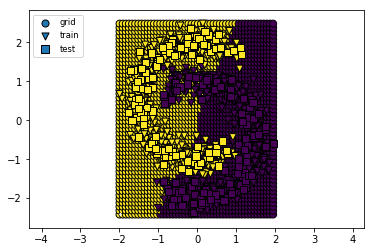

Model Parameters: Number of hidden units: 30, Early Stopping: True, Regularization: [0, 0], Learning Rate: 0.03
Best Validation accuracy:0.77727272727272723
(2500, 2)


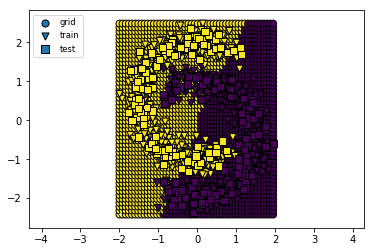

Model Parameters: Number of hidden units: 30, Early Stopping: True, Regularization: [0.001, 0.001], Learning Rate: 0.01
Best Validation accuracy:0.88636363636363635
(2500, 2)


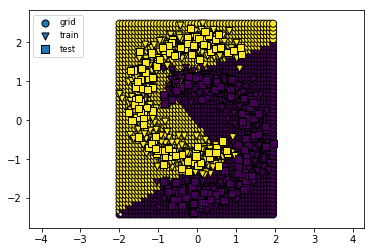

Model Parameters: Number of hidden units: 30, Early Stopping: True, Regularization: [0.001, 0.001], Learning Rate: 0.03
Best Validation accuracy:0.76818181818181819
(2500, 2)


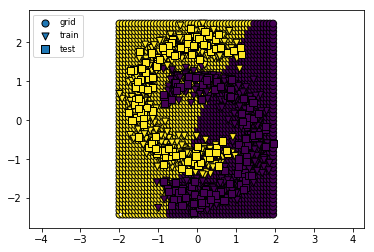

Model Parameters: Number of hidden units: 30, Early Stopping: False, Regularization: [0, 0], Learning Rate: 0.01
Best Validation accuracy:0.88636363636363635
(2500, 2)


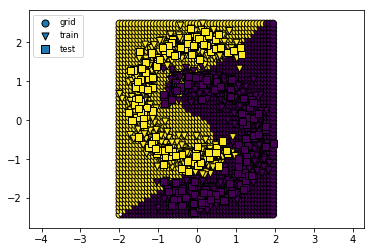

Model Parameters: Number of hidden units: 30, Early Stopping: False, Regularization: [0, 0], Learning Rate: 0.03
Best Validation accuracy:0.98636363636363633
(2500, 2)


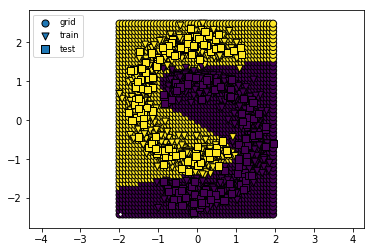

Model Parameters: Number of hidden units: 30, Early Stopping: False, Regularization: [0.001, 0.001], Learning Rate: 0.01
Best Validation accuracy:0.88181818181818183
(2500, 2)


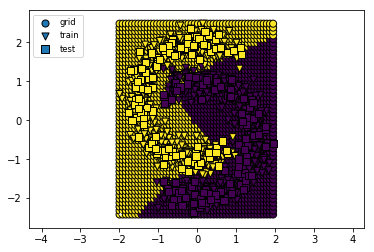

Model Parameters: Number of hidden units: 30, Early Stopping: False, Regularization: [0.001, 0.001], Learning Rate: 0.03
Best Validation accuracy:0.98181818181818181
(2500, 2)


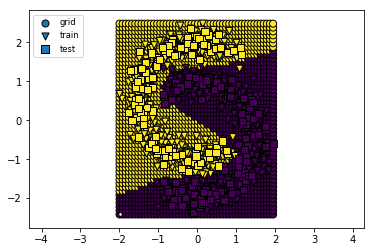

Model Parameters: Number of hidden units: 100, Early Stopping: True, Regularization: [0, 0], Learning Rate: 0.01
Best Validation accuracy:0.76818181818181819
(2500, 2)


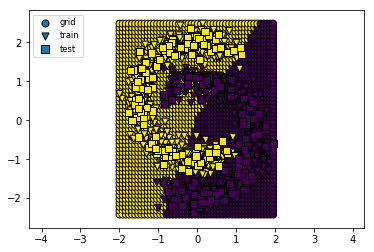

Model Parameters: Number of hidden units: 100, Early Stopping: True, Regularization: [0, 0], Learning Rate: 0.03
Best Validation accuracy:0.78636363636363638
(2500, 2)


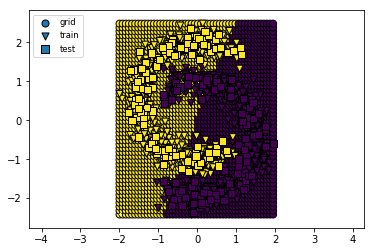

Model Parameters: Number of hidden units: 100, Early Stopping: True, Regularization: [0.001, 0.001], Learning Rate: 0.01
Best Validation accuracy:0.77272727272727271
(2500, 2)


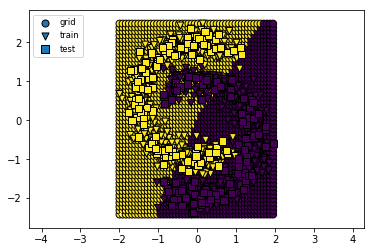

Model Parameters: Number of hidden units: 100, Early Stopping: True, Regularization: [0.001, 0.001], Learning Rate: 0.03
Best Validation accuracy:0.78636363636363638
(2500, 2)


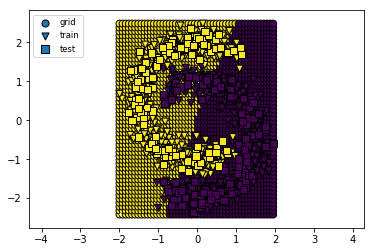

Model Parameters: Number of hidden units: 100, Early Stopping: False, Regularization: [0, 0], Learning Rate: 0.01
Best Validation accuracy:0.92272727272727273
(2500, 2)


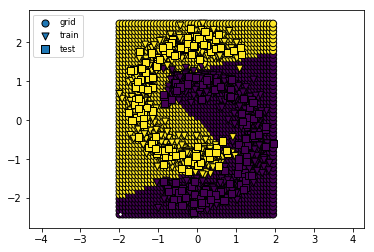

Model Parameters: Number of hidden units: 100, Early Stopping: False, Regularization: [0, 0], Learning Rate: 0.03
Best Validation accuracy:0.99090909090909096
(2500, 2)


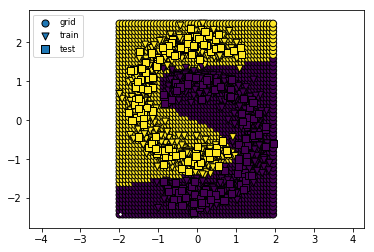

Model Parameters: Number of hidden units: 100, Early Stopping: False, Regularization: [0.001, 0.001], Learning Rate: 0.01
Best Validation accuracy:0.89090909090909087
(2500, 2)


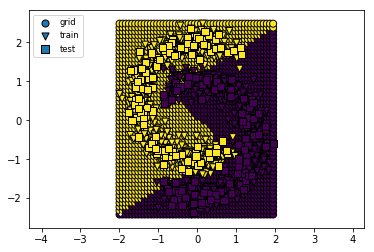

Model Parameters: Number of hidden units: 100, Early Stopping: False, Regularization: [0.001, 0.001], Learning Rate: 0.03
Best Validation accuracy:0.98181818181818181
(2500, 2)


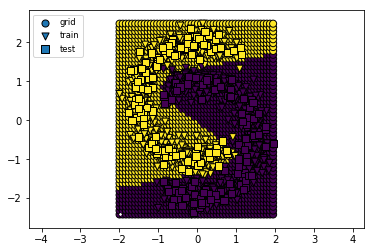

In [108]:
hyperparameters = {
    'n_hidden_units' : [[2,30,2],[2,100,2]],
    'early_stopping' : [True,False],
    'regularization' : [[0,0], [.001,.001]],
    'learning_rate' : [0.01,0.03]
}

for i in range(len(hyperparameters['n_hidden_units'])):
    for j in range(len(hyperparameters['early_stopping'])):
        for k in range(len(hyperparameters['regularization'])):
            for m in range(len(hyperparameters['learning_rate'])):
                print "Model Parameters: Number of hidden units: " + repr(hyperparameters['n_hidden_units'][i][1]) +\
                ", Early Stopping: " + repr(hyperparameters['early_stopping'][j]) + ", Regularization: " +\
                repr(hyperparameters['regularization'][k]) + ", Learning Rate: " + repr(hyperparameters['learning_rate'][m]) 
                model = NeuralNet_single(hyperparameters['n_hidden_units'][i],2,hyperparameters['regularization'][k])
                best_validation_accuracy = model.train(data_train,data_val,hyperparameters['learning_rate'][m],batch_size=25,
                            early_stopping=hyperparameters['early_stopping'][j],num_epochs=200,verbose=False)
                print "Best Validation accuracy:" + repr(best_validation_accuracy)
                gridplot(model,data_train_val,data_test)

In [218]:
def softmax(x):
    b = np.max(x)
    numerator = np.exp(x-b)
    probs = numerator/np.sum(numerator,axis=1,keepdims=True)
    return probs #Normalized probabilities of each class

class NeuralNet_matrix:
    
    def __init__(self,dimensions,num_classes,weight_decay=[0,0]):
        self.weights = [0]*(len(dimensions)-1)
        self.biases = [0]*(len(dimensions)-1)
        for i in range(len(dimensions)-1):
            self.weights[i] = np.random.uniform(low=(-1)/float((np.sqrt(dimensions[i]))),
                                                high=(1)/float((np.sqrt(dimensions[i]))),
                                                size=((dimensions[i+1],dimensions[i]))
                                               )
            self.biases[i] = np.zeros((dimensions[i+1]))   
        self.num_classes = num_classes
        self.weight_decay = weight_decay
    def loss(self,probs,labels):
        N = probs.shape[0]
        loss = -np.sum((np.log(probs[np.arange(N),labels])))
        loss /= N
        loss += self.weight_decay[0]*(np.sum(np.abs(self.weights[0]))+np.sum(np.abs(self.weights[1]))) + \
                self.weight_decay[1]*(np.sum(np.square(self.weights[0]))+ np.sum(np.square(self.weights[1])))
        
        
        return loss
    
    def fprop(self,inp,labels=None):

        N = inp.shape[0]
        #determine product of all dimensions
        D = np.prod(inp.shape[1:])
        #reshape inputs to Number of examples x product of all dimensions
        data = inp.reshape((N,D))

        activations1 = np.dot(data,self.weights[0].T) + self.biases[0]
        
        hidden1 = np.maximum(0,activations1)
        activations2 = np.dot(hidden1,self.weights[1].T) + self.biases[1]
        probs = softmax(activations2)
        if (type(labels) == type(None)):
            return probs
        labels = labels.astype(np.int)
        loss = self.loss(probs,labels)
        cache = (inp,activations1,hidden1,activations2,probs,labels)
        return loss, cache


    def bprop(self,cache):
        inp, activations1, hidden1, activations2, probs,labels = cache
        N = inp.shape[0]
        #grads of softmax function
        grad_oa = probs
        grad_oa[np.arange(labels.shape[0]),labels] -= 1
        
        grad_W2 = np.dot(grad_oa.T,hidden1)/N
        grad_b2 = np.sum(grad_oa,axis=0)/N
        grad_hs = np.dot(grad_oa,(self.weights[1]))

        #Gradient through Relu nonlinearity
        grad_ha = grad_hs*(np.where(activations1>0,1,0))

        #grads of input layer
        grad_W1 = np.dot(grad_ha.T,inp)/N
        grad_b1 = np.sum(grad_ha,axis=0)/N
        grad_inp = np.dot(grad_ha,(self.weights[0]))/N
        
        grad_W1 += self.weight_decay[0]*(np.sign(self.weights[0])) + self.weight_decay[1]*2*(self.weights[0])
        grad_W2 += self.weight_decay[0]*(np.sign(self.weights[1])) + self.weight_decay[1]*2*(self.weights[1])

        return (grad_inp, grad_W1, grad_b1, grad_ha, grad_hs,grad_W2, grad_b2, grad_oa)
        
    def grad_check(self,data,epsilon, batch_size = 1):
        
        inp = data[:batch_size,:-1]
        labels = data[:batch_size,-1]
        labels = labels.astype(int)
        actual_loss, cache = self.fprop(inp,labels)
        
        (_,grad_W1, grad_b1, _,_,grad_W2,grad_b2,_) = self.bprop(cache)
        #Gradient check on b2
        for i in range(self.biases[1].shape[0]):
            self.biases[1][i] += epsilon
            loss_perturbed_b2,_ = self.fprop(inp,labels)
            self.biases[1][i] -= epsilon
            check_grad = (loss_perturbed_b2-actual_loss)/epsilon
            if grad_b2[i] == 0:
                print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_b2[i]+epsilon))
            else:
                print 'Ratio of grads: ' + repr(check_grad/grad_b2[i])
            print 'Gradient b2[' + repr(i) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_b2[i])
        #Gradient check on W2 weights
        for i in range(self.weights[1].shape[0]):
            for j in range(self.weights[1].shape[1]):
                self.weights[1][i,j] += epsilon
                loss_perturbed_W2,_ = self.fprop(inp,labels)
                self.weights[1][i,j] -= epsilon
                check_grad = (loss_perturbed_W2-actual_loss)/epsilon
                if grad_W2[i,j] == 0:
                    print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_W2[i,j]+epsilon))
                else:
                    print 'Ratio of grads: ' + repr(check_grad/grad_W2[i,j])
                print 'Gradient W2[' + repr(i) + ',' + repr(j) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_W2[i,j])


        #Gradient check on b1
        for i in range(self.biases[0].shape[0]):
            self.biases[0][i] += epsilon
            loss_perturbed_b1,_ = self.fprop(inp,labels)
            self.biases[0][i] -= epsilon
            check_grad = (loss_perturbed_b1-actual_loss)/epsilon
            if grad_b1[i] == 0:
                print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_b1[i]+epsilon))
            else:
                print 'Ratio of grads: ' + repr(check_grad/grad_b1[i])
            print 'Gradient b1[' + repr(i) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_b1[i])
        #Gradient check on W1 weights
        for i in range(self.weights[0].shape[0]):
            for j in range(self.weights[0].shape[1]):
                self.weights[0][i,j] += epsilon
                loss_perturbed_W1,_ = self.fprop(inp,labels)
                self.weights[0][i,j] -= epsilon
                check_grad = (loss_perturbed_W1-actual_loss)/epsilon
                if grad_W1[i,j] == 0:
                    print 'Ratio of grads: ' + repr((check_grad+epsilon)/(grad_W1[i,j]+epsilon))
                else:
                    print 'Ratio of grads: ' + repr(check_grad/grad_W1[i,j])
                print 'Gradient W1[' + repr(i) + ',' + repr(j) + ']: Finite difference: ' + repr(check_grad) + ' Analytical: ' + repr(grad_W1[i,j])

                    
    def train(self,data_train,learning_rate,batch_size,num_epochs=1,verbose=True,data_val=None,data_test=None):
        num_steps = int(float(data_train.shape[0]/float(batch_size)))
        self.train_error_epoch = [0]*num_epochs
        self.total_train_loss = [0]*num_epochs
        self.average_train_loss = [0]*num_epochs
        if (type(data_val) != type(None)):
            self.val_error = [0]*num_epochs
            self.val_loss = [0]*num_epochs
        if (type(data_test) != type(None)):
            self.test_error = [0]*num_epochs
            self.test_loss = [0]*num_epochs
        for epoch in range(num_epochs):
            for step in range(num_steps):
                lower_bound = (step*batch_size)%data_train.shape[0]
                upper_bound =(((step+1)*batch_size)%data_train.shape[0])
                if upper_bound < lower_bound:
                    upper_bound = data_train.shape[0]
                features = data_train[lower_bound:upper_bound,:-1]
                labels = data_train[lower_bound:upper_bound,-1]
                batch_loss, cache = self.fprop(features,labels)
                self.total_train_loss[epoch] += batch_loss
                self.train_error_epoch[epoch] += self.compute_error(data_train[(step*batch_size):(step+1)*batch_size,:])
                (grad_inp, grad_W1, grad_b1, grad_ha, grad_hs,grad_W2, grad_b2, grad_oa) = self.bprop(cache)
                
                #Apply gradient descent
                self.weights[0] -= learning_rate*grad_W1
                self.biases[0] -= learning_rate*grad_b1
                self.weights[1] -= learning_rate*grad_W2
                self.biases[1] -= learning_rate*grad_b2
                #accuracy = self.eval_accuracy(data_val)
            self.train_error_epoch[epoch] /= float(data_train.shape[0])
            self.average_train_loss[epoch] = self.total_train_loss[epoch]/float(data_train.shape[0])
            if (type(data_val) != type(None)):
                self.val_error[epoch] = 1-self.eval_accuracy(data_val)
                self.val_loss[epoch],_ = self.fprop(data_val[:,:-1],data_val[:,-1])
            if (type(data_test) != type(None)):
                self.test_error[epoch] = 1-self.eval_accuracy(data_test)
                self.test_loss[epoch],_ = self.fprop(data_test[:,:-1],data_test[:,-1])

            if (verbose):
                print "Epoch: " + repr(epoch+1) + ", Total Training Loss: " + repr(self.total_train_loss[epoch]) + \
                      ", Average Training Loss: " + repr(self.average_train_loss[epoch]) + ", Training Error: "+ repr(self.train_error_epoch[epoch])
                if (type(data_val) != type(None)):
                    print "Validation Loss: " + repr(self.val_loss[epoch]) + ", Validation Error: " + repr(self.val_error[epoch])
                if (type(data_test) != type(None)):
                    print "Test Loss: " + repr(self.test_loss[epoch]) + ", Test Error: " + repr(self.test_error[epoch])

    def eval_accuracy(self,data):
        features = data[:,:-1]
        labels = data[:,-1]
        onehotlabels = onehotify(labels,self.num_classes)
        probs = self.compute_predictions(features)
        predictions = np.argmax(probs,axis=1)
        accuracy = np.mean(np.equal(predictions,labels))
        return accuracy
    
    def compute_predictions(self,features):
        N = features.shape[0]
        probs = self.fprop(features)
        return probs

    def compute_error(self,data):
        features = data[:,:-1]
        labels = data[:,-1]
        probs = self.compute_predictions(features)
        predictions = np.argmax(probs,axis=1)
        correct = np.sum(np.equal(predictions,labels))
        error = data.shape[0] - correct
        return error

Experiment 7: Gradient Check for Matrix and looping, batch size = 1

In [121]:
NN = NeuralNet_matrix([2,2,2],2,[10,10])
NN_single = NeuralNet_single([2,2,2],2,[10,10])
#set initial weights to be the same
NN_single.weights = NN.weights
NN_single.biases = NN.biases
batch_size=1

NN.grad_check(batch_data,0.00001,batch_size)
NN_single.grad_check(batch_data,0.00001,batch_size)


Ratio of grads: 0.99993903909323512
Gradient b2[0]: Finite difference: -0.018364405462989453 Analytical: -0.018365525042049229
Ratio of grads: 1.0000609479499243
Gradient b2[1]: Finite difference: 0.018366644383149833 Analytical: 0.018365525042049236
Ratio of grads: 0.99999547873581063
Gradient W2[0,0]: Finite difference: -22.222909569791224 Analytical: -22.223010045890724
Ratio of grads: 1.0000071203322642
Gradient W2[0,1]: Finite difference: 14.107643083605124 Analytical: 14.107542633214143
Ratio of grads: 1.0000076509712341
Gradient W2[1,0]: Finite difference: 13.132666559556581 Analytical: 13.132566082671252
Ratio of grads: 0.99999537044039055
Gradient W2[1,1]: Finite difference: -21.697306394230509 Analytical: -21.697406843668862
Ratio of grads: 1.0000073378195875
Gradient b1[0]: Finite difference: 0.054504749158468251 Analytical: 0.054504349215386973
Ratio of grads: 1.0000013802489487
Gradient b1[1]: Finite difference: 0.17461752079839241 Analytical: 0.17461727978307556
Ratio of 

Experiment 7: Gradient Check for Matrix and looping, batch size = 1

In [126]:
NN = NeuralNet_matrix([2,2,2],2,[10,10])
NN_single = NeuralNet_single([2,2,2],2,[10,10])
#set initial weights to be the same
NN_single.weights = NN.weights
NN_single.biases = NN.biases
batch_size=10

NN.grad_check(batch_data,0.00001,batch_size)
NN_single.grad_check(batch_data,0.00001,batch_size)

Ratio of grads: 1.0000370988270306
Gradient b2[0]: Finite difference: 0.032780654635189421 Analytical: 0.032779438556468254
Ratio of grads: 0.99996290024732293
Gradient b2[1]: Finite difference: -0.032778222447404914 Analytical: -0.032779438556468254
Ratio of grads: 1.0000058637854425
Gradient W2[0,0]: Finite difference: 17.087983108154958 Analytical: 17.087882908475915
Ratio of grads: 0.9999947455138527
Gradient W2[0,1]: Finite difference: -19.10605748420835 Analytical: -19.106157877250244
Ratio of grads: 0.99999466703302942
Gradient W2[1,0]: Finite difference: -18.788491427557119 Analytical: -18.788591626495688
Ratio of grads: 0.99999389792824978
Gradient W2[1,1]: Finite difference: -16.452118852328113 Analytical: -16.452219244950395
Ratio of grads: 1.00000289844201
Gradient b1[0]: Finite difference: 0.072909334392079472 Analytical: 0.072909123069214266
Ratio of grads: 1.0000068707778016
Gradient b1[1]: Finite difference: 0.0014372304235621412 Analytical: 0.0014372205487390988
Ratio 

MNIST Data Prep

In [161]:
import gzip,pickle
f=gzip.open('../mnist.pkl.gz')
data_MNIST=pickle.load(f)
data_train_MNIST = np.array(data_MNIST[0][0])
labels_train_MNIST = np.matrix(data_MNIST[0][1])

data_train_MNIST = np.concatenate((data_train_MNIST,labels_train_MNIST.T),axis=1)
data_train_MNIST = np.array(data_train_MNIST)

data_val_MNIST = np.array(data_MNIST[1][0])
labels_val_MNIST = np.matrix(data_MNIST[1][1])
data_val_MNIST = np.concatenate((data_val_MNIST,labels_val_MNIST.T), axis=1)
data_val_MNIST = np.array(data_val_MNIST)

data_test_MNIST = np.array(data_MNIST[2][0])
labels_test_MNIST = np.matrix(data_MNIST[2][1])

data_test_MNIST = np.concatenate((data_test_MNIST,labels_test_MNIST.T),axis=1)
data_test_MNIST = np.array(data_test_MNIST)

Experiment 8: Time Epoch length with batch size = 100

In [203]:
import time
NN_mnist_matrix = NeuralNet_matrix([data_train_MNIST.shape[1]-1,95,10],10)
NN_mnist_loop = NeuralNet_single([data_train_MNIST.shape[1]-1,95,10],10)

start_time_matrix = time.time()
NN_mnist_matrix.train(data_train_MNIST,0.01,100,num_epochs=1,verbose=False)
fin_time_matrix = time.time()
tot_time_matrix = fin_time_matrix - start_time_matrix

start_time_loop = time.time()
NN_mnist_loop.train(data_train_MNIST, data_val_MNIST,0.01,100,num_epochs=1, verbose=False)
fin_time_loop = time.time()
tot_time_loop = fin_time_loop - start_time_loop
print "Matrix epoch time: " + repr(tot_time_matrix) + " Loop epoch time: " +  repr(tot_time_loop) 

Matrix epoch time: 0.6946618556976318 Loop epoch time: 11.089022874832153


Experiment 9: Calculate Train Error, Train Loss for each step. Calculate the Average Train Error per Epoch. Calculate Test Error, and Validation Error at the end of each epoch

In [221]:
NN_matrix_final = NeuralNet_matrix([data_train_MNIST.shape[1]-1,200,10],10,[0.0001,0.0001])
NN_matrix_final.train(data_train_MNIST,0.01,100,num_epochs=20, data_val = data_val_MNIST, data_test=data_test_MNIST,verbose=True)

Epoch: 1, Total Training Loss: 968.90587237814441, Average Training Loss: 0.01937811744756289, Training Error: 0.32600000000000001
Validation Loss: 1.245932666212469, Validation Error: 0.16249999999999998
Test Loss: 1.2533159903361326, Test Error: 0.17220000000000002
Epoch: 2, Total Training Loss: 518.4721120747995, Average Training Loss: 0.010369442241495989, Training Error: 0.15801999999999999
Validation Loss: 0.8454955632497726, Validation Error: 0.12180000000000002
Test Loss: 0.86000129706277229, Test Error: 0.12909999999999999
Epoch: 3, Total Training Loss: 411.71672743713231, Average Training Loss: 0.0082343345487426462, Training Error: 0.12889999999999999
Validation Loss: 0.7328814214954078, Validation Error: 0.10860000000000003
Test Loss: 0.74647867094821851, Test Error: 0.11529999999999996
Epoch: 4, Total Training Loss: 371.60392671813651, Average Training Loss: 0.0074320785343627302, Training Error: 0.11626
Validation Loss: 0.68009703699486623, Validation Error: 0.10219999999